# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


    class Model:
        
        def predict(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of predicted classes.

        def certainty(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of certainty levels.

# Solutions
## 1. Model stem definition

<img src="images/resnet50_architecture.png" alt="Alternative text" />

#### Model has been developed in Pytorch Lightning framework. It contains model architecture, based on above stem. Residual connections are defined within BlockWithResiduals() declaration.

In [ ]:
import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch.nn as nn
import numpy as np
import sys

class BlockWithResiduals(pl.LightningModule):
    def __init__(self, channels, start_expansion, end_expansion, stride):
        super(BlockWithResiduals, self).__init__()
        self.start_expansion = start_expansion
        self.end_expansion = end_expansion
        self.stride = stride
        self.residual_rescale = None

        self.conv_1 = nn.Conv2d(in_channels=channels*self.start_expansion, 
                                out_channels=channels, 
                                kernel_size=1, 
                                stride=1, 
                                padding=0)
        self.batch_norm_1 = nn.BatchNorm2d(channels)
        self.conv_2 = nn.Conv2d(in_channels=channels, 
                                out_channels=channels, 
                                kernel_size=3, 
                                stride=self.stride, 
                                padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(channels)
        self.conv_3 = nn.Conv2d(in_channels=channels, 
                                out_channels=self.end_expansion*channels, 
                                kernel_size=1, 
                                stride=1, 
                                padding=0)
        self.batch_norm_3 = nn.BatchNorm2d(self.end_expansion*channels)

        if self.start_expansion != self.end_expansion:
            self.residual_rescale = nn.Sequential(
                    nn.Conv2d(channels*self.start_expansion, 
                            channels*self.end_expansion, 
                            kernel_size=1, 
                            stride=self.stride),
                    nn.BatchNorm2d(channels*self.end_expansion)
                )

        self.relu = nn.ReLU()

    def forward(self, x):
        input_x = x.clone()
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.batch_norm_3(self.conv_3(x))

        # skip connection
        if self.residual_rescale is not None:
            input_x = self.residual_rescale(input_x)
        x = self.relu(x + input_x)

        return x

class MyResNet50(pl.LightningModule):
    def __init__(self, lr):
        super(MyResNet50, self).__init__()
        self.in_channels = 64
        self.expansion = 4
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

        self.input_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.blocks_layers_1 = self.make_initial_blocks_layer(sublayers_num=3, bl_channels=64, stride=1)
        self.blocks_layers_2 = self.make_blocks_layer(sublayers_num=4, bl_channels=128, stride=2)
        self.blocks_layers_3 = self.make_blocks_layer(sublayers_num=6, bl_channels=256, stride=2)
        self.blocks_layers_4 = self.make_blocks_layer(sublayers_num=3, bl_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*self.expansion, 10)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.input_conv(x)))
        x = self.max_pool(x)
        x = self.blocks_layers_1(x)
        x = self.blocks_layers_2(x)
        x = self.blocks_layers_3(x)
        x = self.blocks_layers_4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def make_initial_blocks_layer(self, sublayers_num, bl_channels, stride):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=1, end_expansion=self.expansion, stride=stride))
            else:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion, stride=stride))

        return nn.Sequential(*blocks_layers)

    def make_blocks_layer(self, sublayers_num, bl_channels, stride):
        blocks_layers = []
        for i in range(sublayers_num):
            if i == 0:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=2, end_expansion=self.expansion, stride=stride))
            else:
                blocks_layers.append(BlockWithResiduals(channels=bl_channels, start_expansion=self.expansion, end_expansion=self.expansion, stride=1))          
                

        return nn.Sequential(*blocks_layers)

    def training_step(self, batch, batch_nb):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)

        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_nb):
        x_val, y_val = batch
        preds_val = self(x_val)
        loss_val = self.loss_fn(preds_val, y_val)

        accuracy = Accuracy().to(self.device)
        acc = accuracy(preds_val, y_val)
        self.log('accuracy', acc, on_epoch=True)
        self.log("validation_loss", loss_val, on_epoch=True)

        return loss_val
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=0.0001)
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5),
            # "interval": "epoch",
            "monitor": "validation_loss",
            # "frequency": 5
        },
    }

    def predict(self, input_array: np.ndarray) -> np.ndarray:
        # Given a batch of examples return a batch of predicted classes.
        preds_val = self(torch.Tensor(input_array))
        
        return preds_val.cpu().detach().numpy()

    def certainty(self, input_array: np.ndarray) -> np.ndarray:
        # Given a batch of examples return a batch of certainty levels.
        predictions = self.predict(input_array)
        epsilon = sys.float_info.min

        predictive_entropies = []
        for pred in predictions:
            pe = -np.sum( np.mean(pred, axis=0) * np.log(np.mean(pred, axis=0) + epsilon),
                    axis=-1)
            predictive_entropies.append(pe)

        return predictive_entropies


# 2. Train model

#### Model was trained and monitored using MLFlow Tracking framework. Best 5 models (based on Accuracy) were saved for future use.

In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import pytorch_lightning as pl
from ResNet50Model import MyResNet50
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import mlflow
import mlflow.pytorch
from mlflow import MlflowClient

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Training_resnet50")


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100*batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


model = MyResNet50(lr=0.1)
# model = RN50(lr=0.1)
# print(model)

# checkpoint = torch.load('saved_models/resnet50_model-epoch=87-train_loss=0.28-validation_loss=0.48-accuracy=0.85.ckpt')
# model.load_state_dict(checkpoint["state_dict"])

checkpoint_callback = ModelCheckpoint(
    monitor='accuracy',
    mode = 'max',
    save_top_k=5,
    dirpath='saved_models/',
    filename='resnet50_model-{epoch:02d}-{train_loss:.2f}-{validation_loss:.2f}-{accuracy:.2f}'
)

trainer = pl.Trainer(max_epochs=200, accelerator='gpu', devices=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)

#### Trained model achieved 85% accuracy on test CIFAR10 dataset after around 50 epochs. Model weights have ben saved as "resnet50_model-epoch=87-train_loss=0.28-validation_loss=0.48-accuracy=0.85.ckpt"

Accuracy:

<img src="images/model_acc.png" alt="Alternative text" />

Train and validation loss:

<img src="images/model_loss.png" alt="Alternative text" />

## 3. Predictions and certainity

In [14]:
import torchvision
import torch
import torchvision.transforms as transforms
import pytorch_lightning as pl
from ResNet50Model import MyResNet50
from pytorch_lightning.callbacks import ModelCheckpoint
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100*batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


model = MyResNet50(lr=0.1)
checkpoint = torch.load('saved_models/resnet50_model-epoch=87-train_loss=0.28-validation_loss=0.48-accuracy=0.85.ckpt')
model.load_state_dict(checkpoint["state_dict"])

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [15]:
dataiter = iter(testloader)
X, y = dataiter.next()

In [16]:
preds = model.predict(X[:100, :, :])

Predicted: car
Truth: car


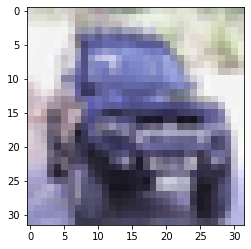

In [40]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

i = 9
print(f'Predicted: {classes[np.argmax(preds[i])]}')
print(f'Truth: {classes[y[i].numpy()]}')
imshow(torchvision.utils.make_grid(X[i]))

In [46]:
model.certainty(X[:20, :, :])

[0.026302399153978258,
 0.028250319773006585,
 0.0039607040429147184,
 0.018827739409375523,
 nan,
 0.015041275029540349,
 nan,
 nan,
 0.007275566758382923,
 nan,
 0.023026286614148146,
 nan,
 0.021460558269905332,
 nan,
 nan,
 0.013289527810962437,
 0.03893904409625127,
 0.014147028433266453,
 0.03016917995977774,
 0.017578514911552594]

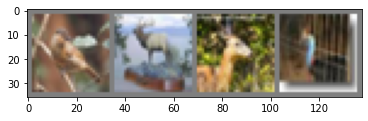

bird  deer  deer  bird 


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))